# Kaggle Project 13 - Binary Classification with Kidney Stone Data

## Prepared By: Dwaipayan Mukherjee (2211569, AIA - AIML)

## About the Project:

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Kidney Stone Prediction based on Urine Analysis dataset. Feature distributions are close to, but not exactly the same, as the original.

The original dataset can be used to predict the presence of kidney stones based on urine analysis. The 79 urine specimens, were analyzed in an effort to determine if certain physical characteristics of the urine might be related to the formation of calcium oxalate crystals.

The six physical characteristics of the urine are: 

1. specific gravity, the density of the urine relative to water; 

2. pH, the negative logarithm of the hydrogen ion; 

3. osmolarity (mOsm), a unit used in biology and medicine but not in physical chemistry. Osmolarity is proportional to the concentration of molecules in solution; 

4. conductivity (mMho milliMho). One Mho is one reciprocal Ohm. Conductivity is proportional to the concentration of charged ions in solution; 

5. urea concentration in millimoles per litre; and 

6. calcium concentration (CALC) in millimolesllitre.

## 1. Necessary Imports:

Here I first import the basic libraries needed for working: NumPy, Pandas, and the visualization libraries matplotlib and seaborn.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [38]:
from collections import OrderedDict
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, RocCurveDisplay,roc_auc_score
import lightgbm as lgbm
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

## 2. Loading the train, test, original and submission datasets as Pandas Dataframes:

Since all the datasets are in csv format, and I want to load it as Pandas dataframes, I have used the `pd.read_csv()` method that reads the csv files as Pandas dataframes.

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
original = pd.read_csv('kindey stone urine analysis.csv')

## 3. Understanding the data

First I will look into the heads of the datasets: train, test, original and submissions. The `head()` allows us to look at the top 5 rows of the datasets. We can even put in a number in the parenthesis of `heads()` to view the number of rows mentioned. 

In [4]:
train.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [5]:
test.head()

,id,gravity,ph,osmo,cond,urea,calc
0,414,1.017,5.24,345,11.5,152,1.16
1,415,1.020,5.68,874,29.0,385,3.46
2,416,1.024,5.36,698,19.5,354,13.00
3,417,1.020,5.33,668,25.3,252,3.46
4,418,1.011,5.87,567,29.0,457,2.36


In [6]:
original.head()

,gravity,ph,osmo,cond,urea,calc,target
0,1.021,4.91,725,14.0,443,2.45,0
1,1.017,5.74,577,20.0,296,4.49,0
2,1.008,7.20,321,14.9,101,2.36,0
3,1.011,5.51,408,12.6,224,2.15,0
4,1.005,6.52,187,7.5,91,1.16,0


The submission dataset gives us the format in which we have to present the final submission.

In [7]:
submission.head()

,id,target
0,414,0.5
1,415,0.5
2,416,0.5
3,417,0.5
4,418,0.5


I will also check the shapes of the dataframes.

In [8]:
train.shape

(414, 8)

In [9]:
test.shape

(276, 7)

In [10]:
original.shape

(79, 7)

So, using the original 79 urine samples, the synthetic data of 414 urine samples have been made and saved as training data. There are 276 urine samples that act as the testing data. Note that the train data has 8 columns while the original and testing data only have 7 columns. This is because the original data does not have an `id` column which the train and test data have, and the test data does not have the target column (the one which we have to predict).

The next step in understanding the dataset is viewing the information about the columns. To do this, we will use the `info()` on the train, test and original datasets. This will give us the datatypes of the different columns and the non-null counts.

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       414 non-null    int64  
 1   gravity  414 non-null    float64
 2   ph       414 non-null    float64
 3   osmo     414 non-null    int64  
 4   cond     414 non-null    float64
 5   urea     414 non-null    int64  
 6   calc     414 non-null    float64
 7   target   414 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 26.0 KB


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       276 non-null    int64  
 1   gravity  276 non-null    float64
 2   ph       276 non-null    float64
 3   osmo     276 non-null    int64  
 4   cond     276 non-null    float64
 5   urea     276 non-null    int64  
 6   calc     276 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 15.2 KB


In [13]:
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gravity  79 non-null     float64
 1   ph       79 non-null     float64
 2   osmo     79 non-null     int64  
 3   cond     79 non-null     float64
 4   urea     79 non-null     int64  
 5   calc     79 non-null     float64
 6   target   79 non-null     int64  
dtypes: float64(4), int64(3)
memory usage: 4.4 KB


Next, we will view the summary statistics like count, mean, standard deviation, minimum value, maximum value and the quantiles for each of the columns for each of the three datasets. We can do so using `describe()`. Note that `.T` is given at the end of the `describe()` command. This allows the summary statistics to be shown in a transpose manner.

In [14]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,414.0,206.500000,119.655756,0.000,103.250,206.500,309.750,413.00
gravity,414.0,1.017894,0.006675,1.005,1.012,1.018,1.022,1.04
ph,414.0,5.955459,0.642260,4.760,5.530,5.740,6.280,7.94
osmo,414.0,651.545894,234.676567,187.000,455.250,679.500,840.000,1236.00
cond,414.0,21.437923,7.514750,5.100,15.500,22.200,27.600,38.00
urea,414.0,278.657005,136.442249,10.000,170.000,277.000,385.000,620.00
calc,414.0,4.114638,3.217641,0.170,1.450,3.130,6.630,14.34
target,414.0,0.444444,0.497505,0.000,0.000,0.000,1.000,1.00


In [15]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,276.0,551.500000,79.818544,414.000,482.7500,551.500,620.25000,689.000
gravity,276.0,1.018330,0.006569,1.005,1.0140,1.019,1.02325,1.034
ph,276.0,5.939312,0.607143,4.900,5.5300,5.730,6.21000,7.940
osmo,276.0,654.891304,236.361932,187.000,456.0000,658.000,843.25000,1236.000
cond,276.0,21.886594,7.346069,5.100,17.4000,23.600,27.60000,38.000
urea,276.0,280.985507,134.877856,64.000,168.5000,282.000,385.00000,620.000
calc,276.0,4.076848,3.088524,0.170,1.5275,3.230,5.54000,14.340


In [16]:
original.describe().T

,count,mean,std,min,25%,50%,75%,max
gravity,79.0,1.018114,0.007239,1.005,1.012,1.018,1.0235,1.04
ph,79.0,6.028481,0.724307,4.760,5.530,5.940,6.3850,7.94
osmo,79.0,612.848101,237.514755,187.000,413.000,594.000,792.0000,1236.00
cond,79.0,20.813924,7.938994,5.100,14.150,21.400,26.5500,38.00
urea,79.0,266.405063,131.254550,10.000,160.000,260.000,372.0000,620.00
calc,79.0,4.138987,3.260051,0.170,1.460,3.160,5.9300,14.34
target,79.0,0.430380,0.498293,0.000,0.000,0.000,1.0000,1.00


## 4. Dealing with missing values:

Here we need to check if there are any missing values in the three datasets. If there are any missing values, then we will need to deal with them.

### Looking for missing values

In order to look for missing values, we use `.isna()` method. Now this method shows in boolean whether a value is missing or not in each of the columns. We can summarize this entire boolean matrix using the `sum()` method, so that it shows whether there are any missing values in each of the columns.

In [17]:
print("\n Missing values in train data: \n")
print(train.isna().sum())

print("\n Missing values in test data: \n")
print(test.isna().sum())

print("\n Missing values in original data: \n")
print(original.isna().sum())


 Missing values in train data: 

id         0
gravity    0
ph         0
osmo       0
cond       0
urea       0
calc       0
target     0
dtype: int64

 Missing values in test data: 

id         0
gravity    0
ph         0
osmo       0
cond       0
urea       0
calc       0
dtype: int64

 Missing values in original data: 

gravity    0
ph         0
osmo       0
cond       0
urea       0
calc       0
target     0
dtype: int64


There are no missing values in the train, test or the original dataset. This is good news. So, we do not need to worry about dealing with any missing values. In case missing values were present, we would have to figure out imputations to deal with them, or if the missing values in a particular columns was too high, we might have to drop it.

## 5. Unique Values:

We will check for unique values in the columns. 

### Unique Value Counts:

In order to find the number of unique values, we use the `nunique()` method. I have used a `for-loop` on the names of the columns in each of the datasets, and then the number of unique values in each of the columns is found using the `nunique()` method.

In [18]:
print("Unique Value Counts")

print("\n---------train----------\n")
for i in train.columns:
    print(f'{i}: {train[i].nunique()}')

print("\n---------test----------\n")
for i in test.columns:
    print(f'{i}: {test[i].nunique()}')
    
print("\n---------original----------\n")
for i in original.columns:
    print(f'{i}: {original[i].nunique()}')

Unique Value Counts

---------train----------

id: 414
gravity: 28
ph: 71
osmo: 80
cond: 65
urea: 73
calc: 85
target: 2

---------test----------

id: 276
gravity: 27
ph: 62
osmo: 75
cond: 58
urea: 71
calc: 74

---------original----------

gravity: 29
ph: 70
osmo: 77
cond: 64
urea: 73
calc: 75
target: 2


From this, we can understand that the only categorical column is the `target` column having only two values. All the other columns are continuous variables. This is necessary to understand for a meaningful exploratory data analysis.

## 6. Distribution of the `target` variable:

It is very important to look at the distribution of the `target` variable in the training dataset. This informs us whether the training dataset is balanced or unbalanced. In case the training dataset is highly unbalanced, we might need to do some extra things to make it more balanced before training any model on it.

The `value_counts()` method gives us the frequency of each unique value in a column. 

In [19]:
train['target'].value_counts()

0    230
1    184
Name: target, dtype: int64

So, its evident that the distribution is a bit unbalanced. However, this would not make much problem. Still, I will be using Stratified k-fold Cross Validation while training the data, so that this mild unbalance is taken care of.

## 7. Exploratory Data Analysis:

In this section, we will use the visualization libraries to understand the data and the distributions of different columns in the data. This allows us to have a better understanding of the dataset as well as to make choices about the columns and the models that we would use to predict the test data.

We will be doing a few exercises, namely:
1. Distribution of the `target` in the train and the original dataset.
2. Distribution of the other features in the datasets and the distribution of the `target` with respect to them.

### 7.1 Distribution of the `target` variable in the train and the original dataset:

Here, first we set up the colour palette. We use the `cubehelix_palette()` module from the `seaborn` library throughout this notebook.

We divide the space for the pictures into two spaces column-wise using the `plt.subplots()` method and set the figure size to 14x5 using the `figsize` argument. The name of the figure is set using the `fig.suptitle()` method, along with the desired font size set using the `fontsize` argument.

We show the distribution of the `target` column in the train and original datasets using pie charts. For this, we have first set the titles using the `set_title()` method, then we have used the `value_counts()` method on the target column of the train and original datasets and stored them in two variables `plot_data_train` and `plot_data_original` respectively. We have renamed the categories from 0 and 1 to Kidney Stone Absent and Kidney Stone Present. Lastly, we have done the pie charts using the `pie()` method.

([<matplotlib.patches.Wedge at 0x1a992966a00>,
 [Text(-0.23867668382652718, 1.0737939469924256, '0: Kidney stone absent'),
  Text(0.23867668382652682, -1.0737939469924258, '1: Kidney Stone present')],
 [Text(-0.13018728208719663, 0.5857057892685957, '57.0%'),
  Text(0.13018728208719643, -0.5857057892685958, '43.0%')])

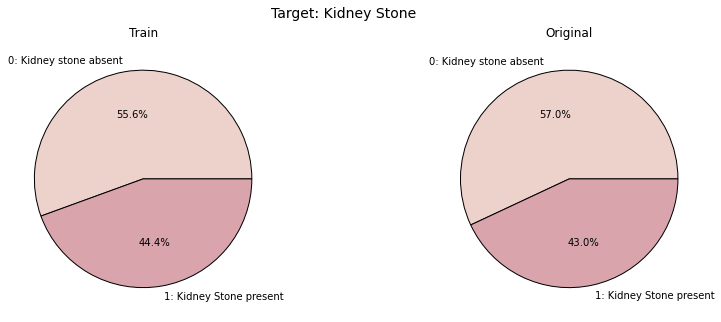

In [20]:
## Setting up the color pallette
colors = sns.cubehelix_palette()

## Setting up the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

## Setting up the figure title
fig.suptitle("Target: Kidney Stone", fontsize=14)

## Pie chart showing the distribution of target in train and original datasets:
ax[0].set_title('Train')
ax[1].set_title('Original')
plot_data_train = train['target'].value_counts()
plot_data_original = original['target'].value_counts()
plot_labels_train = plot_data_train.rename(index={0:'0: Kidney stone absent', 1:'1: Kidney Stone present'}).index
plot_labels_original = plot_data_original.rename(index={0:'0: Kidney stone absent', 1:'1: Kidney Stone present'}).index
ax[0].pie(plot_data_train, labels=plot_labels_train, autopct='%1.1f%%', colors=colors, wedgeprops = dict(edgecolor='black'))
ax[1].pie(plot_data_original, labels=plot_labels_original, autopct='%1.1f%%', colors=colors, wedgeprops = dict(edgecolor='black'))

We find that the distribution of the `target` column is more or less the same in both the train and the original datasets. This ensures us that the synthetically generated training data is representative of the original dataset. This implies that we can merge these two datasets to make a new and larger training dataset to train our models on. This will be done later on in the notebook. 

### 7.2 Distribution of the other features in the datasets and the distribution of the target with respect to them:

We will first separate out the features from the datasets.

In [21]:
features = [col for col in train.columns]
features

['id', 'gravity', 'ph', 'osmo', 'cond', 'urea', 'calc', 'target']

The `target` column is not a feature. So we drop it.

In [22]:
features.remove('target')
features

['id', 'gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']

The `id` feature is not present in the original dataset. Moreover, this column does not provide any signal towards the presence or absence of the stone in kidney. So we can remove it.

In [23]:
features.remove('id')
features

['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']

Now we will dive into the EDA on these features.

We use a `for-loop` to do the same set of code for each of the features. Fisrt we set the style using `sns.set_style()` method. We also divide the space for the pictures into two spaces column-wise using the `plt.subplots()` method and set the figure size to 24x5 using the `figsize` argument. The name of the figure is set using the `fig.suptitle()` method, along with the desired font size set using the `fontsize` argument.

Next we plot the kernel density estimation plots using `kdeplot()` method of the `seaborn` library. Lastly, we use the `boxplot()` method to plot the boxplots in order to view the distribution of the `target` variable with respect to each of the features in the training dataset.

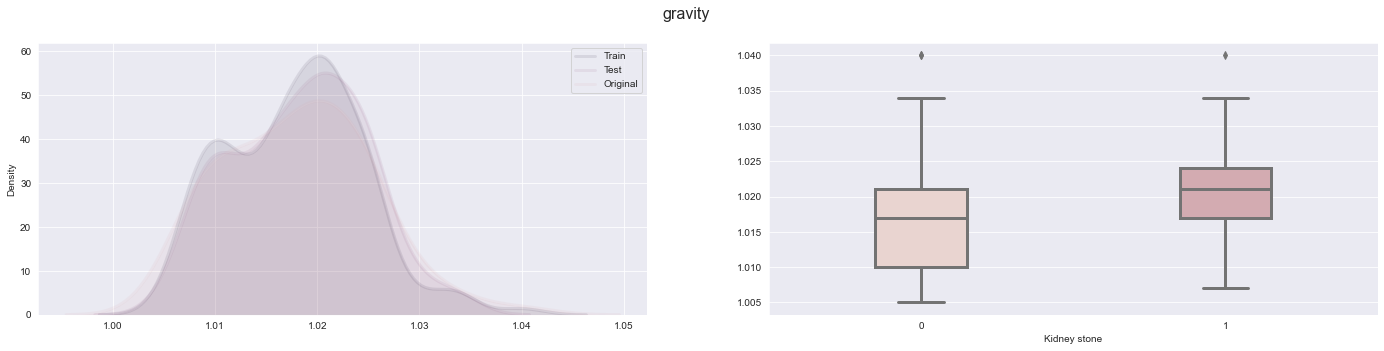

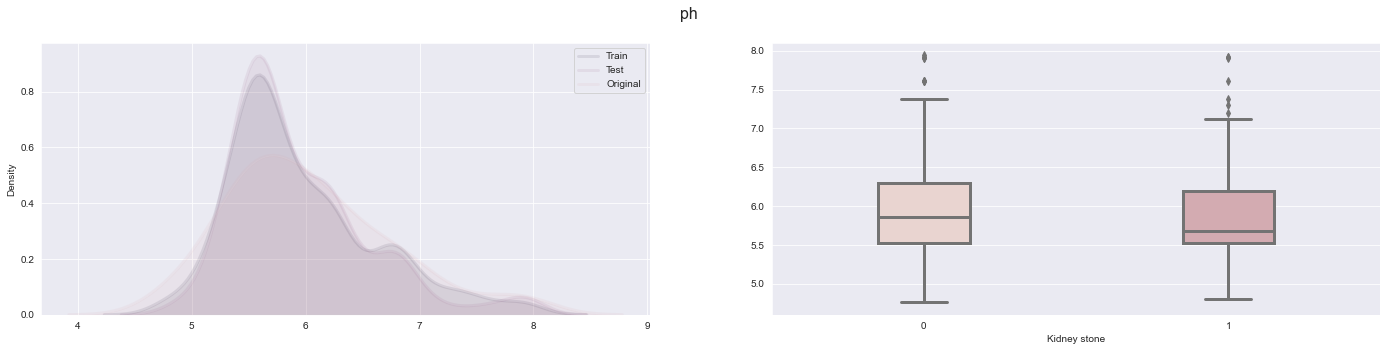

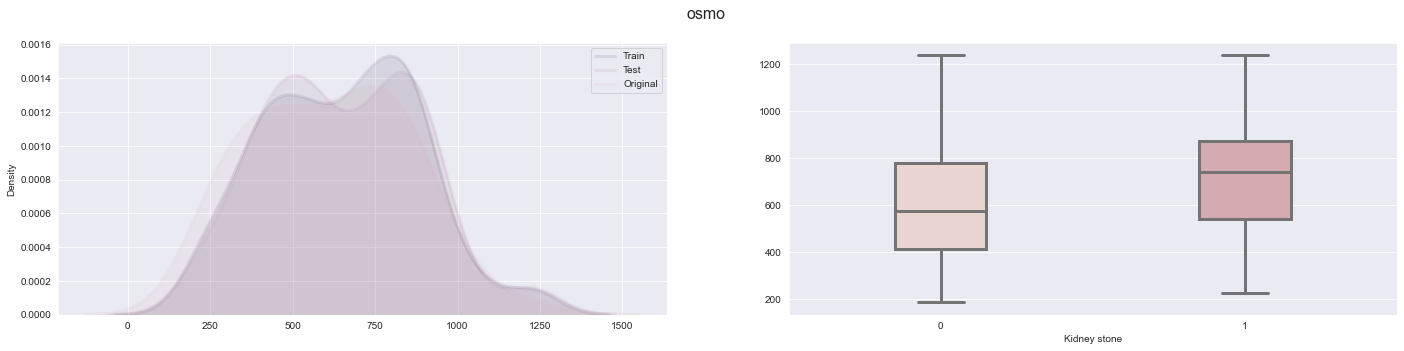

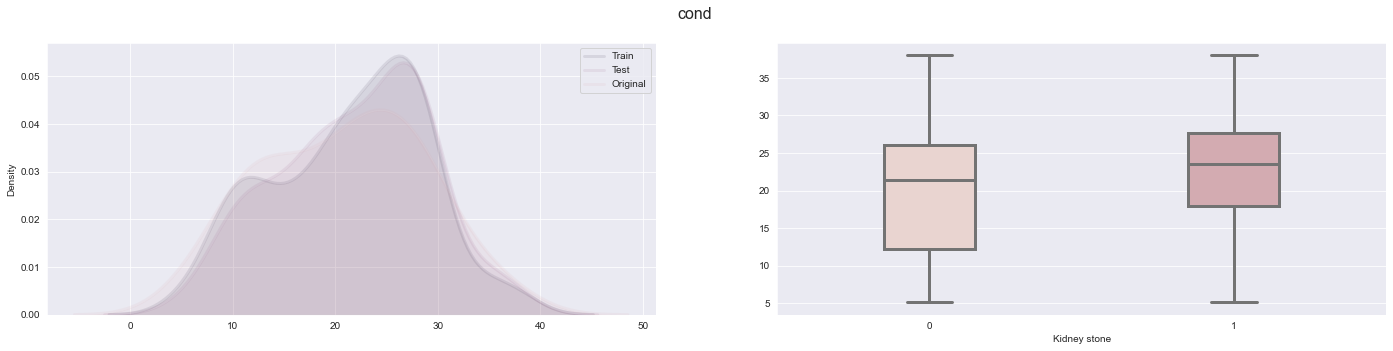

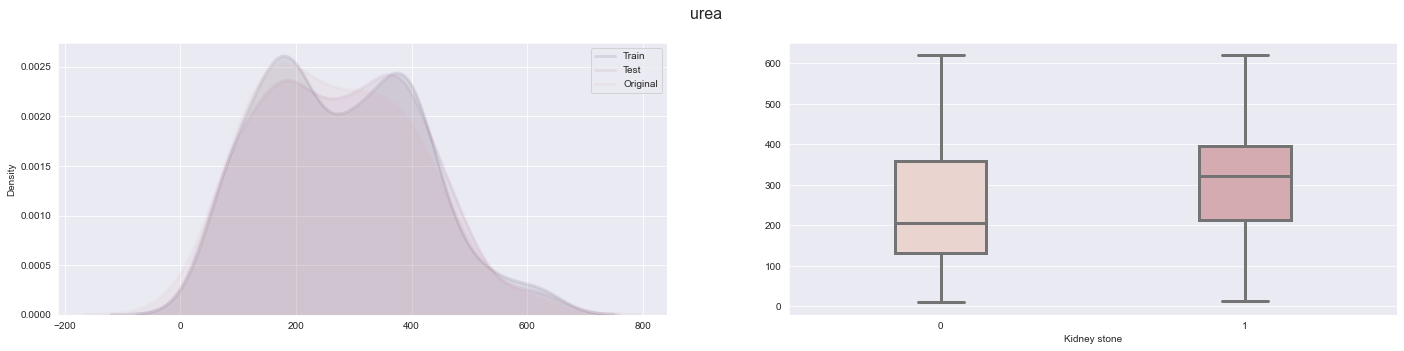

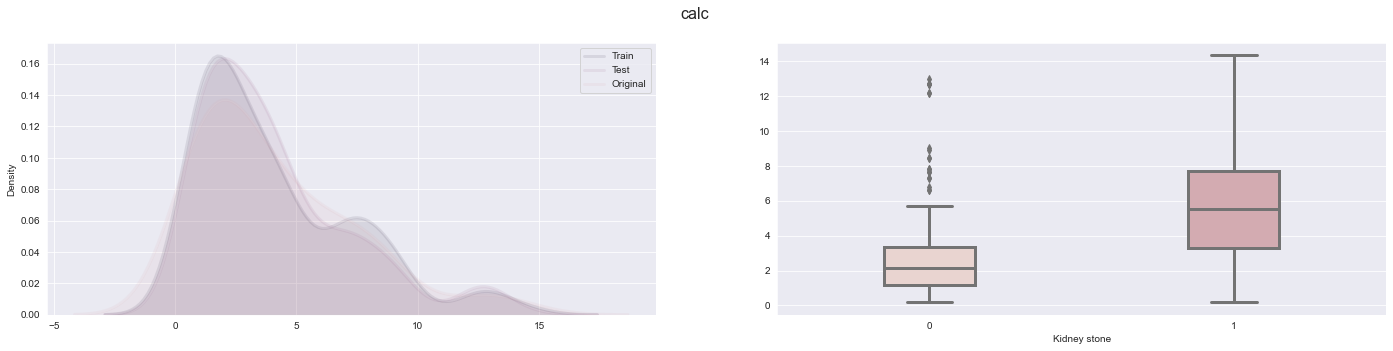

In [24]:
for i in features:
    
    ## Setting the figure and axes
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(1, 2, figsize = (24,5))
    
    ## Setting the figure title
    fig.suptitle(i, fontsize = 16)
    
    ## train/test/original differences
    sns.kdeplot(train[i], shade=True, color = colors[5], ax = ax[0], label = "Train", alpha = 0.1, linewidth = 3)
    sns.kdeplot(test[i], shade=True, color = colors[3], ax = ax[0], label = "Test", alpha = 0.1, linewidth = 3)
    sns.kdeplot(original[i], shade=True, color = colors[1], ax = ax[0], label = "Original", alpha = 0.1, linewidth = 3)
    ax[0].set_xlabel('')
    ax[0].set_ylabel('Density')
    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(handles, labels)
    
    
    ## Boxplots
    sns.boxplot(y=i, x='target', data = train, width = 0.3, ax=ax[1], palette = colors, linewidth = 3)
    ax[1].set_xlabel('Kidney stone')
    ax[1].set_ylabel('')

We see that the distribution of each feature is quite different for the urine samples if a kidney stone is present or absent. This tells us that these features are good signals for predicting using urine samples if a kidney stone is present or not. 

## 8. Data Preparation:

Here we prepare the data for training the models. There are a few steps that we will go through in this section:
1. Getting rid of unnecessary `id` column, since this does not provide any signal towards the presence or absence of a Kidney stone.
2. Merging the train and original data to form a more extensive training dataset.
3. Separating the features and the target columns.

### 8.1 Removing `id` column from train and test datasets:

To drop a column from a pandas dataframe, we use the `drop()` method, along with the `axis=1` argument that informs the `drop()` method that a column has to be dropped and the `inplace=True` argument that informs the `drop()` method that the said column has to be permanently removed from the dataframe.

In [25]:
train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

In [26]:
train.head()

,gravity,ph,osmo,cond,urea,calc,target
0,1.013,6.19,443,14.8,124,1.45,0
1,1.025,5.40,703,23.6,394,4.18,0
2,1.009,6.13,371,24.5,159,9.04,0
3,1.021,4.91,442,20.8,398,6.63,1
4,1.021,5.53,874,17.8,385,2.21,1


In [27]:
test.head()

,gravity,ph,osmo,cond,urea,calc
0,1.017,5.24,345,11.5,152,1.16
1,1.020,5.68,874,29.0,385,3.46
2,1.024,5.36,698,19.5,354,13.00
3,1.020,5.33,668,25.3,252,3.46
4,1.011,5.87,567,29.0,457,2.36


In [28]:
original.head()

,gravity,ph,osmo,cond,urea,calc,target
0,1.021,4.91,725,14.0,443,2.45,0
1,1.017,5.74,577,20.0,296,4.49,0
2,1.008,7.20,321,14.9,101,2.36,0
3,1.011,5.51,408,12.6,224,2.15,0
4,1.005,6.52,187,7.5,91,1.16,0


### 8.2 Merging the `train` and `original` datasets:

To merge the `train` and the `original` datasets, we use the `pd.concat()` method, along with the `axis=0` argument that informs the method to concat the two dataframes along the rows and the `ignore_index=False` argument that informs the method to ignore the index of the individual dataframes.

In [29]:
train_data = pd.concat([train, original], axis=0, ignore_index=True)
train_data.shape

(493, 7)

In [30]:
train_data.head()

,gravity,ph,osmo,cond,urea,calc,target
0,1.013,6.19,443,14.8,124,1.45,0
1,1.025,5.40,703,23.6,394,4.18,0
2,1.009,6.13,371,24.5,159,9.04,0
3,1.021,4.91,442,20.8,398,6.63,1
4,1.021,5.53,874,17.8,385,2.21,1


### 8.3 Separating the features and the target:

We need to separate the features and the target columns in the training data to fit the models.

In [31]:
X = train_data.drop(['target'], axis=1)
y = train_data['target']
X_test = test.copy()

## 9. Modeling:

Here we will use the following three models to train and validate:
1. Random Forest Classifier
2. XGBoost Classifier
3. Light GBM Classifier

Note that the evaluation metric that we will use for each model will be **Area under the ROC Curve**. We will use a 5-fold Stratified Cross Validation strategy to train and evaluate each model.

To make it easier to implement, I will create a function named `cross_validate()` to do the training and evaluation easily.

**cross_validate() function:**

This function takes in the features data, the target values and the model we want to train. So this function can be used for any model we would like to train.

I have first set the fiure and axis to plot the AUC curve and the importances list. In this I have first set the style to darkgrid using `sns.set_style()` method. Next, I have used the `plt.subplots()` method to divide the figure space into two spaces row-wise: one for the ROC-AUC curve and the other for the Importances. I have also labeled the axes and titles using the `set_xlabel()`, `set_ylabel()` and `set_title()` methods.

Next, I have initialized the Stratified K-fold CV using the `StratifiedKFold()` method. The argument `n_splits=5` informs the method that a 5-fold stratified cross-validation has to be performed and the `shuffle=True` argument allows for random sampling.

Two lists are created named `cv_scores` and `model_importances` to store the cross-validation AUC scores and the feature importances. Then the data is split and the model is fitted. The cv_scores are calculated and stored.The feature importances are then converted into a Pandas dataframe which is then used to plot a horizontal bar graph.

In [32]:
def cross_validate(X, y, model):
    
    ## Figure, axes:
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(2, 1, figsize=(8,12))
    ax[0].set_title("ROC-AUC Curve")
    ax[0].set_xlabel("False Positive Rate")
    ax[0].set_ylabel("True Positive Rate")
    ax[1].set_title("Importances")
    
    
    skf = StratifiedKFold(n_splits = 5,
                          shuffle = True,
                          random_state = 1337)
    cv_scores = []
    model_importances = []
    
    for fold, (train_id, val_id) in enumerate(skf.split(X, y)):
        X_train, X_valid = X.loc[train_id], X.loc[val_id]
        y_train, y_valid = y.loc[train_id], y.loc[val_id]
        
        model.fit(X_train, y_train)
        model_importances.append(model.feature_importances_)
        
        y_pred = model.predict_proba(X_valid)[:, 1]
        auc_score = roc_auc_score(y_valid, y_pred)
        cv_scores.append(auc_score)
        fpr, tpr, thresholds = roc_curve(y_valid, y_pred)
        roc_auc = auc(fpr, tpr)
        display = RocCurveDisplay(fpr = fpr,
                        tpr = tpr,
                        roc_auc = roc_auc,
                        estimator_name = 'model')
        display.plot(ax = ax[0])
        
        print(f'Fold {fold} \t auc: {auc_score}')
        print('\n-------------------------------\n')
    
    df_importances = pd.DataFrame(model_importances,
                                  columns = train.drop(['target'], axis=1).columns).apply(np.mean, axis=0).sort_values()
    df_importances.plot(kind = 'barh',
                        align = 'center',
                        width = 0.4,
                        ax = ax[1],
                        color = 'blue',
                        edgecolor = 'black')
    
    avg_auc = np.mean(cv_scores)
    print(f"Average AUC: {avg_auc}")

### 9.1 Random Forest Classifier:

We initialize the Random Forest Classifier model using the `RandomForestClassifier()`. We pass the following arguments:
* `n_estimators=200`, which initializes 200 trees in the forest;
* `max_depth = 5`, argument informs the classifier that the maximum depth of a tree cannot exceed 5. 
* `random_state = 42`, random seed argument.  

Then we pass the features, the target and the Random Forest Classifier model into the `cross_validate()` function.

Fold 0 	 auc: 0.8152892561983471

-------------------------------

Fold 1 	 auc: 0.8495867768595042

-------------------------------

Fold 2 	 auc: 0.7962809917355372

-------------------------------

Fold 3 	 auc: 0.7369978858350951

-------------------------------

Fold 4 	 auc: 0.8367864693446089

-------------------------------

Average AUC: 0.8069882759946185


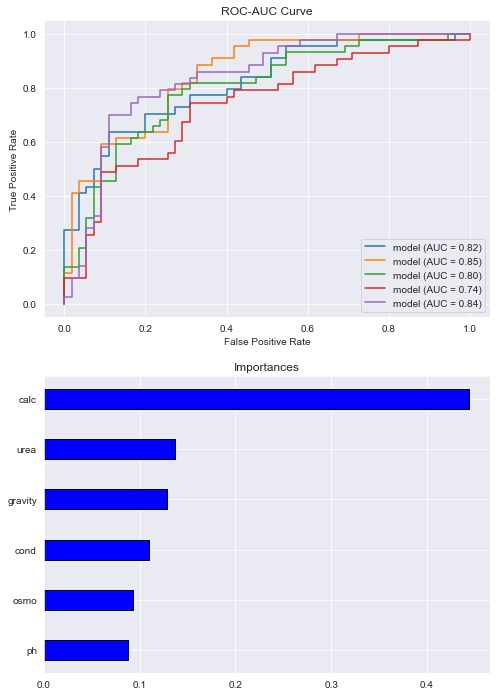

In [33]:
rf_model = RandomForestClassifier(n_estimators=400,
                                  max_depth = 5,
                                  random_state = 42)
cross_validate(X, y, rf_model)

### 9.2 XGBoost Classifier:

Here I use the XGBoost Classifier model. I have first initialized the model using `XGBClassifier()`. I have used the following hyperparameters:

| Hyperparameter | Definition | My Choice |
|:--------------:|:----------:|:---------:|
| `n_estimators` | The number of boosting rounds or trees to build | 400 |
| `max_depth` | The maximum depth of each tree | 5 |
| `learning_rate` | The step size shrinkage used to prevent overfitting | 0.1 |
| `min_child_weight` | The minimum sum of weights of all observations required in a child | 5 |
| `subsample` | Fraction of observations to be randomly sampled for each tree | 0.7 |
| `colsample_bytree` | Fraction of columns to be randomly sampled for each tree | 0.25 |

Then I have passed the features data, the target data and the model into the `cross_validate()` function for model training and evaluation.

Fold 0 	 auc: 0.8066115702479338

-------------------------------

Fold 1 	 auc: 0.8

-------------------------------

Fold 2 	 auc: 0.7613636363636364

-------------------------------

Fold 3 	 auc: 0.7657505285412262

-------------------------------

Fold 4 	 auc: 0.8363636363636363

-------------------------------

Average AUC: 0.7940178743032865


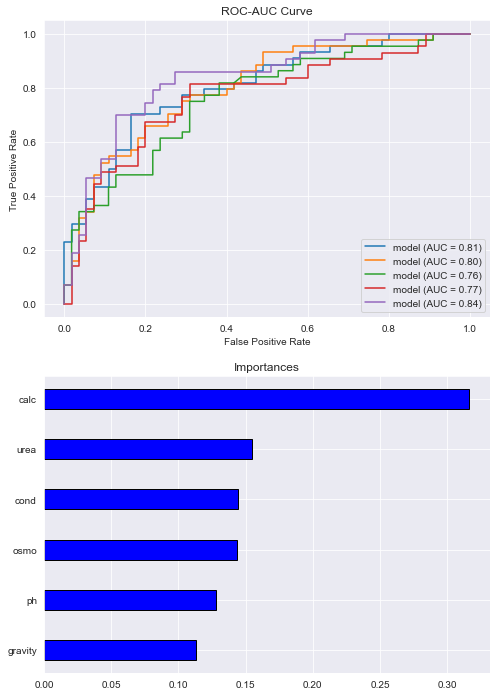

In [34]:
xgb_model = XGBClassifier(n_estimators = 400,
                          max_depth = 5,
                          learning_rate = 0.1,
                          min_child_weight = 5,
                          subsample = 0.7,
                          colsample_bytree = 0.25)

cross_validate(X, y, xgb_model)

### 9.3 Light GBM Classifier: 

Here I use the LGBM Classifier model, and so I have used `lgbm.LGBMClassifier()` to initialize the model. The following hyperparameters are used:

| Hyperparameter | Definition | My Choice |
|:--------------:|:----------:|:---------:|
| `n_estimators` | Number of trees to build | 400 |
| `learning_rate` | The step size shrinkage used to prevent overfitting | 0.1 |
| `num_leaves` | The maximum number of leaves in each decision tree | 200 |
| `max_depth` | The maximum depth of each tree | 5 |
| `min_data_in_leaf` | The minimum number of samples required to be at a leaf node | 45 |
| `lambda_l1` | L1 regularization term on the weights | 0.01 |
| `lambda_l2` | L2 regularization term on the weights | 0.6 |
| `min_gain_to_split` | The minimum gain required to make a further partition on a leaf node of the tree | 1.40 |
| `bagging_fraction` | The fraction of observations to be randomly sampled for each tree | 0.7 |
| `feature_fraction` | The fraction of features to be randomly sampled for each tree | 0.25 |

Now I pass the features data, the target data and the model as arguments into the `cross_validate()` function for model training and evaluation.

[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_gain_to_split is set=1.4, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6
Fold 0 	 auc: 0.8107438016528926

-------------------------------

[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_dat

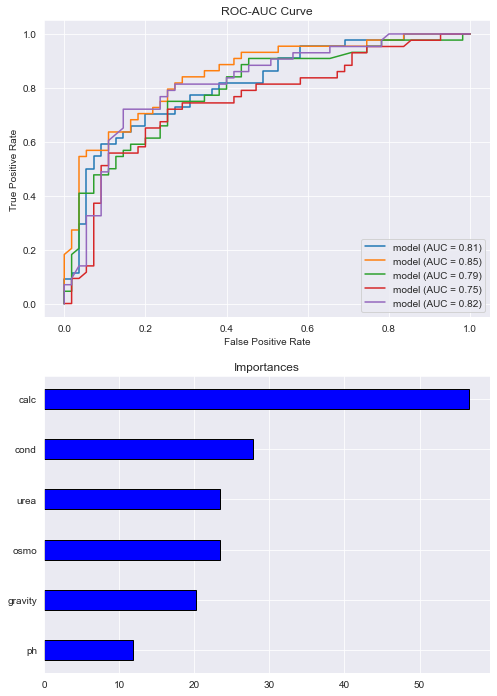

In [37]:
lgbm_model = lgbm.LGBMClassifier(n_estimators = 400,
                                 learning_rate = 0.1,
                                 num_leaves = 200,
                                 max_depth = 5,
                                 min_data_in_leaf = 45,
                                 lambda_l1 = 0.01,
                                 lambda_l2 = 0.6,
                                 min_gain_to_split = 1.40,
                                 bagging_fraction = 0.7,
                                 feature_fraction = 0.25)

cross_validate(X, y, lgbm_model)

**Summarizing the results:**

Till now, I have trained three models and the results are as follows:

| Model | Average AUC score (average of 5 folds) | Top 3 important features (in descending order of importance) |
|:-----:|:-----------------:|:------------------------:|
| Random Forest Classifier | 0.8069882759946185 | calc, urea, gravity |
| XGBoost Classifier | 0.7940178743032865 | calc, urea, cond |
| Light GBM Classifier | 0.8040620795694793 | calc, cond, urea |

Since all three of the models show more or less similar average AUC score, I will use their mean for the prediction on the test set.

## 10. Final Prediction:

In order to make final predictions on the test dataset, I will first train the three models on the entire training data.

In [42]:
rf_model.fit(X, y)

RandomForestClassifier(max_depth=5, n_estimators=400, random_state=42)

In [43]:
xgb_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.25, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [44]:
lgbm_model.fit(X, y)

LGBMClassifier(bagging_fraction=0.7, feature_fraction=0.25, lambda_l1=0.01,
               lambda_l2=0.6, max_depth=5, min_data_in_leaf=45,
               min_gain_to_split=1.4, n_estimators=400, num_leaves=200)

In [47]:
final_pred = (rf_model.predict_proba(X_test)[:, 1] + xgb_model.predict_proba(X_test)[:, 1] + lgbm_model.predict_proba(X_test)[:, 1])/3

In [48]:
submission.head()

,id,target
0,414,0.5
1,415,0.5
2,416,0.5
3,417,0.5
4,418,0.5


In [49]:
submission['target'] = final_pred
submission.head()

,id,target
0,414,0.124424
1,415,0.456555
2,416,0.882620
3,417,0.364774
4,418,0.291721
